## Notebook to analyze TH Prkcd_Grin2c data
Largest subclass group

In [1]:
import numpy as np
import pandas as pd
import anndata as ad
import scanpy as sc
import scipy.io
import scipy.sparse
import matplotlib.pyplot as plt

In [2]:
# Function to create volcano plots
def plotVolcano(dataObj, indx = 0, thresh = 10, label = ["top"]):
    """ Create a volcano plot for given log fold changes and p values. Takes annData 
    object with "rank_gene_groups" field as input. Indx denotes group to look at.
    """
    import matplotlib.pyplot as plt
    import numpy as np
    
    # Clean inputs, check that label is a list rather than string
    if type(label) == str:
        label = [label]
    
    # Get class names
    rankGenes = dataObj.uns["rank_genes_groups"]
    groups = rankGenes["names"].dtype.names
    
    # If indx is an int, find appropriate string conversion
    if type(indx) == int:
        indx = groups[indx]
    
    rankGenes = dataObj.uns["rank_genes_groups"]
    groups = rankGenes["names"].dtype.names
    pVal = rankGenes["pvals_adj"][indx] #pvals_adj
    logFoldChange = rankGenes["logfoldchanges"][indx]

    # Adjust unplottable
    pVal[pVal == 0] = min(pVal[pVal > 0])
    pVal = -np.log10(pVal)
    # Determine how to color points
    upExpressed = (logFoldChange > 3) & (pVal > thresh)
    downExpressed = (logFoldChange < -3) & (pVal > thresh)
    belowThresh = ~(upExpressed | downExpressed)
    
    # Plot genes that fall above and below baseline
    fig = plt.subplots()
    plt.grid(True, which = "both")
    plt.plot(logFoldChange[belowThresh], pVal[belowThresh], '.', color='gray', markersize = 2)
    plt.plot(logFoldChange[upExpressed], pVal[upExpressed], '.', color='green', markersize = 2)
    plt.plot(logFoldChange[downExpressed], pVal[downExpressed], '.', color='blue', markersize = 2)
    plt.xlabel("Log2 Fold Change")
    plt.ylabel("- Log10 ( pVal ) ")
    
    # Check for annotation requests. Default behavior is to annotate the top X genes, otherwise plot requested genes
    if label == ["top"]:
        for i in [0]:
            plt.annotate(rankGenes["names"][indx][i], [logFoldChange[i],pVal[i]])
            plt.annotate(rankGenes["names"][indx][-(i + 1)], [logFoldChange[-(i + 1)],pVal[-(i + 1)]])
    else:
        for i in range(len(label)):
            geneIndx = rankGenes["names"][indx].tolist().index(label[i])
            plt.annotate(label[i], [logFoldChange[geneIndx], pVal[geneIndx]])
    plt.title(indx + ' vs ' + rankGenes["params"]["reference"] + ' reference')
    return fig

# function to create a mask dictionary for umap plotting
def create_mask_dict(names,show_name):
    mask_dict = {}
    for name in names:
        if str(name) == show_name:
            mask_dict[name] = "red"
        else:
            mask_dict[name] = "lightgray"
    return mask_dict

In [3]:
# Load in pre-processed data from glutamatergic class designation, subclass to all rank_gene_groups already performed
gluData = sc.read("../Data/gluData.h5ad")

C:\Users\mathew.summers\Anaconda3\envs\scanpy1.9\lib\site-packages\anndata\_core\anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [4]:
# TH Prkcd_Grin2c is the most common subclass within dataset
gluTypes = gluData.obs.subclass_label.unique()
gluCounts = pd.DataFrame([sum(gluData.obs.subclass_label == name) for name in gluTypes], columns= ["Count"], index = gluTypes)
gluCounts = gluCounts.sort_values(by = "Count", ascending=False)
gluCounts

,Count
TH Prkcd_Grin2c,23362
TH_Rxfp1_Epb4,10411
TH PVT_Ntrk1,5419
TH/HY Gbx2 Zim1,5006
TH MH_Tac2,4405
TH AV_Col27a1,3011
TH PF_Fzd5,2500
TH LH_Pou4f1_Sox1,1346
TH Tfap2d,774
TH Serpinb7,398


In [5]:
# Create a dataframe with list of gene scores, pvals, logfoldchanges, percentage expression
indx = "TH Prkcd_Grin2c"
genesRanked = pd.DataFrame(
        {key: gluData.uns["rank_genes_groups"][key][indx]
        for key in ['names', 'pvals', 'scores', 'logfoldchanges']})
pts = gluData.uns["rank_genes_groups"]["pts"][indx][genesRanked.names].reset_index(drop=True).rename("pts")
pts_rest = gluData.uns["rank_genes_groups"]["pts_rest"][indx][genesRanked.names].reset_index(drop=True).rename("pts_rest")
pts_diff = pd.Series(pts - pts_rest, name="pts_diff")
genesRanked = pd.concat([genesRanked, pts, pts_rest, pts_diff], axis=1)
genesRanked = genesRanked.sort_values(by=["scores"], ascending=False)
genesRanked

,names,pvals,scores,logfoldchanges,pts,pts_rest,pts_diff
0,Atp2b1,0.0,183.133286,3.420255,1.000000,0.985723,0.014277
1,Adarb1,0.0,181.194977,3.290441,0.999700,0.943481,0.056219
2,Ramp3,0.0,180.553741,8.380062,0.981936,0.390716,0.591221
3,Ptpn4,0.0,179.449860,3.480616,0.999914,0.967031,0.032884
4,Rgs7bp,0.0,178.473038,3.278038,0.999957,0.953843,0.046114
...,...,...,...,...,...,...,...
23426,Pnmal2,0.0,-155.632950,-2.797717,0.942299,0.994966,-0.052667
23427,Ahi1,0.0,-156.280563,-4.092157,0.900608,0.985811,-0.085204
23428,Epb41l1,0.0,-159.327225,-5.207674,0.590104,0.944453,-0.354349
23429,Ids,0.0,-163.590240,-4.046320,0.817653,0.989520,-0.171868


(<Figure size 432x288 with 1 Axes>,
 <AxesSubplot:title={'center':'TH Prkcd_Grin2c vs rest reference'}, xlabel='Log2 Fold Change', ylabel='- Log10 ( pVal ) '>)

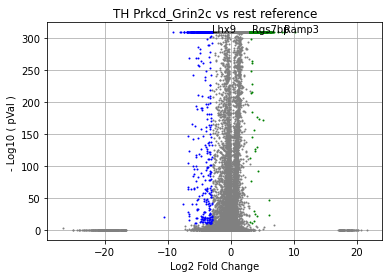

In [147]:
# Create volcano plot
plotVolcano(gluData,indx,label=["Ramp3","Rgs7bp"])

In [9]:
# Take top 500 "score" genes
genesRanked = genesRanked.sort_values(by=["scores"], ascending=False, key=abs)
genesFiltered = genesRanked.iloc[0:500,:]
genesFiltered = genesFiltered.sort_values(by=["pts_diff"], ascending=False)
genesFiltered

,names,pvals,scores,logfoldchanges,pts,pts_rest,pts_diff
5,Prkcd,0.0,178.053619,10.210557,0.933525,0.288275,0.645249
79,Mrvi1,0.0,142.244553,6.756602,0.797963,0.156192,0.641770
109,Grin2c,0.0,136.612091,6.322179,0.773821,0.150157,0.623663
87,Tnnt1,0.0,141.155548,7.450067,0.762478,0.139178,0.623300
86,Cnksr3,0.0,141.294296,6.180892,0.900993,0.307085,0.593908
...,...,...,...,...,...,...,...
23363,Xkr6,0.0,-115.486641,-7.902293,0.048883,0.592182,-0.543299
23391,Dlgap2,0.0,-125.731064,-7.493887,0.101704,0.664331,-0.562628
23415,Alcam,0.0,-141.526062,-8.062936,0.192792,0.774955,-0.582163
23397,Cygb,0.0,-131.010986,-6.952258,0.129655,0.714109,-0.584454


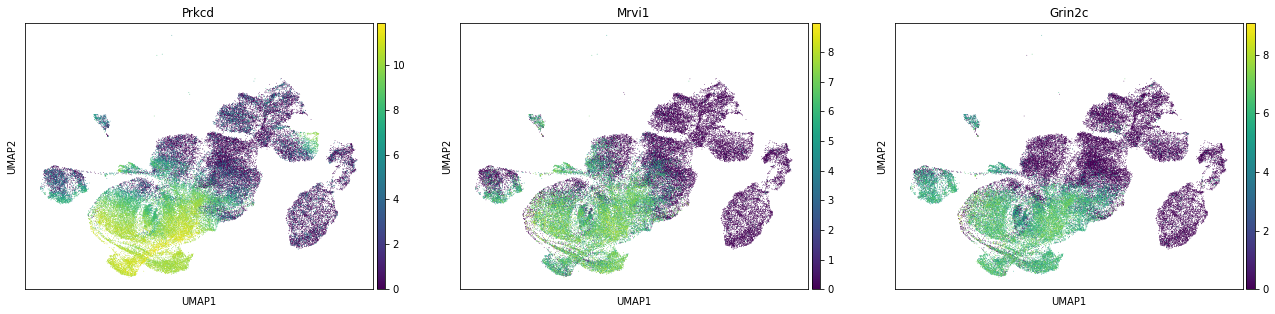

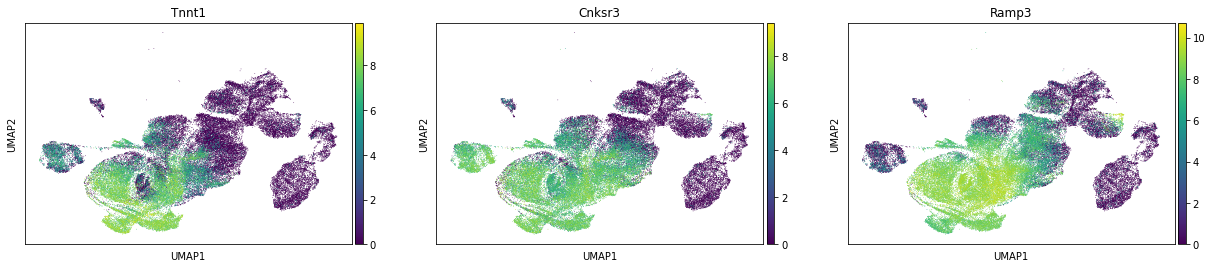

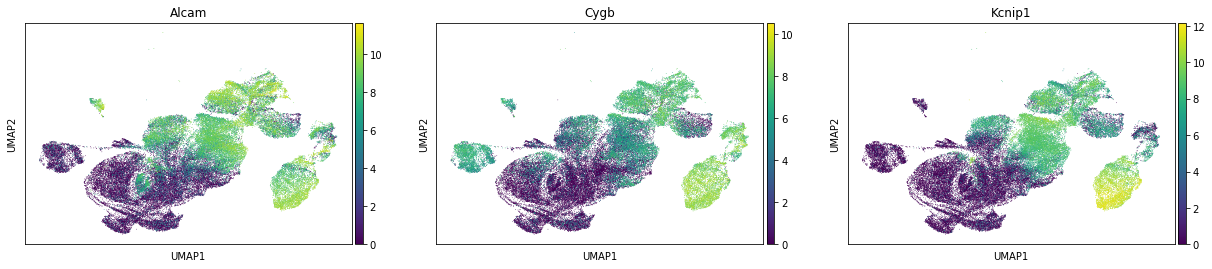

In [10]:
# Plot expression of several potential marker genes
sc.pl.umap(gluData, color = genesFiltered["names"][0:3])
sc.pl.umap(gluData, color = genesFiltered["names"][3:6])
sc.pl.umap(gluData, color = genesFiltered["names"][-3:])

In [16]:
# Look at marker gene overlap
markerGenes = {
    'TH Prkcd_Grin2c' : genesFiltered["names"][:5].tolist(),
    'Downregulated' : genesFiltered["names"][-5:].tolist(),
    'TH Serpinb7' : ["C1ql2", "Stk32b", "Scn7a", "Megf11"],
}
markerOverlap = sc.tl.marker_gene_overlap(gluData,markerGenes,method="jaccard", top_n_markers=50, inplace=False)
markerOverlap

,HY Foxa1,HY Pitx2,TH AV_Col27a1,TH LH_Pou4f1_Sox1,TH MH_Tac2,TH PF_Fzd5,TH PVT_Ntrk1,TH Pitx2,TH Prkcd_Grin2c,TH Serpinb7,TH Tfap2d,TH/HY Gbx2 Fmo1,TH/HY Gbx2 Zim1,TH/HY Pth2,TH_Rxfp1_Epb4
TH Prkcd_Grin2c,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.018519,0.00,0.000000,0.000000,0.000000,0.000000,0.0
Downregulated,0.018519,0.0,0.0,0.037736,0.037736,0.0,0.0,0.018519,0.000000,0.00,0.057692,0.018519,0.037736,0.018519,0.0
TH Serpinb7,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.08,0.000000,0.000000,0.000000,0.000000,0.0


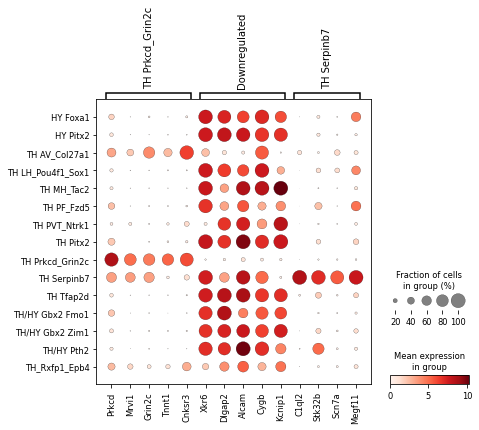

In [17]:
sc.pl.dotplot(gluData,markerGenes,"subclass_label")

## Prkcd Grin2c subcluster analysis
Look at how different various clusters within the Prkcd_Grin2c subclass differ

C:\Users\mathew.summers\Anaconda3\envs\scanpy1.9\lib\site-packages\anndata\compat\_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


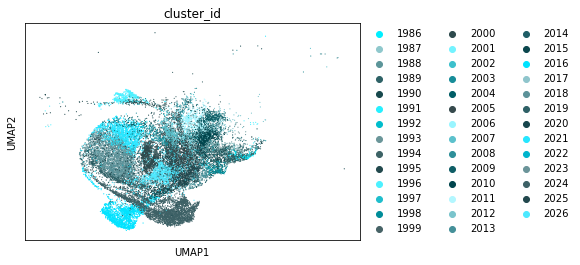

In [18]:
# Index by cell class
indx = "TH Prkcd_Grin2c"
clData = gluData[gluData.obs.subclass_label == indx]
color_dict = dict(zip(clData.obs["cluster_id"],clData.obs["cluster_color"]))
sc.pl.umap(clData, color="cluster_id",palette=color_dict)

In [19]:
# Get counts of each cell
clTypes = clData.obs.cluster_id.unique()
clCounts = pd.DataFrame([sum(clData.obs.cluster_id == name) for name in clTypes], columns= ["Count"], index = clTypes)
clCounts = clCounts.sort_values(by = "Count", ascending=False)
clCounts

,Count
2024,3090
2018,2850
2025,2061
2016,1695
2021,1688
2005,1248
2010,1200
2026,1037
2000,916
2007,742


C:\Users\mathew.summers\Anaconda3\envs\scanpy1.9\lib\site-packages\scanpy\tools\_rank_genes_groups.py:394: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'names'] = self.var_names[global_indices]
C:\Users\mathew.summers\Anaconda3\envs\scanpy1.9\lib\site-packages\scanpy\tools\_rank_genes_groups.py:396: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'scores'] = scores[global_indices]
C:\Users\mathew.summers\Anaconda3\envs\scanpy1.9\lib\site-packages\scanpy\tools\_rank_genes_groups.py:399

C:\Users\mathew.summers\Anaconda3\envs\scanpy1.9\lib\site-packages\scanpy\tools\_rank_genes_groups.py:420: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'logfoldchanges'] = np.log2(
C:\Users\mathew.summers\Anaconda3\envs\scanpy1.9\lib\site-packages\scanpy\tools\_rank_genes_groups.py:394: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'names'] = self.var_names[global_indices]
C:\Users\mathew.summers\Anaconda3\envs\scanpy1.9\lib\site-packages\scanpy\tools\_rank_genes_groups.py:396: Perf

C:\Users\mathew.summers\Anaconda3\envs\scanpy1.9\lib\site-packages\scanpy\tools\_rank_genes_groups.py:409: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'pvals_adj'] = pvals_adj[global_indices]
C:\Users\mathew.summers\Anaconda3\envs\scanpy1.9\lib\site-packages\scanpy\tools\_rank_genes_groups.py:420: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'logfoldchanges'] = np.log2(
C:\Users\mathew.summers\Anaconda3\envs\scanpy1.9\lib\site-packages\scanpy\tools\_rank_genes_groups.py:394: Perfo

C:\Users\mathew.summers\Anaconda3\envs\scanpy1.9\lib\site-packages\scanpy\tools\_rank_genes_groups.py:420: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'logfoldchanges'] = np.log2(
C:\Users\mathew.summers\Anaconda3\envs\scanpy1.9\lib\site-packages\scanpy\tools\_rank_genes_groups.py:394: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'names'] = self.var_names[global_indices]
C:\Users\mathew.summers\Anaconda3\envs\scanpy1.9\lib\site-packages\scanpy\tools\_rank_genes_groups.py:396: Perf

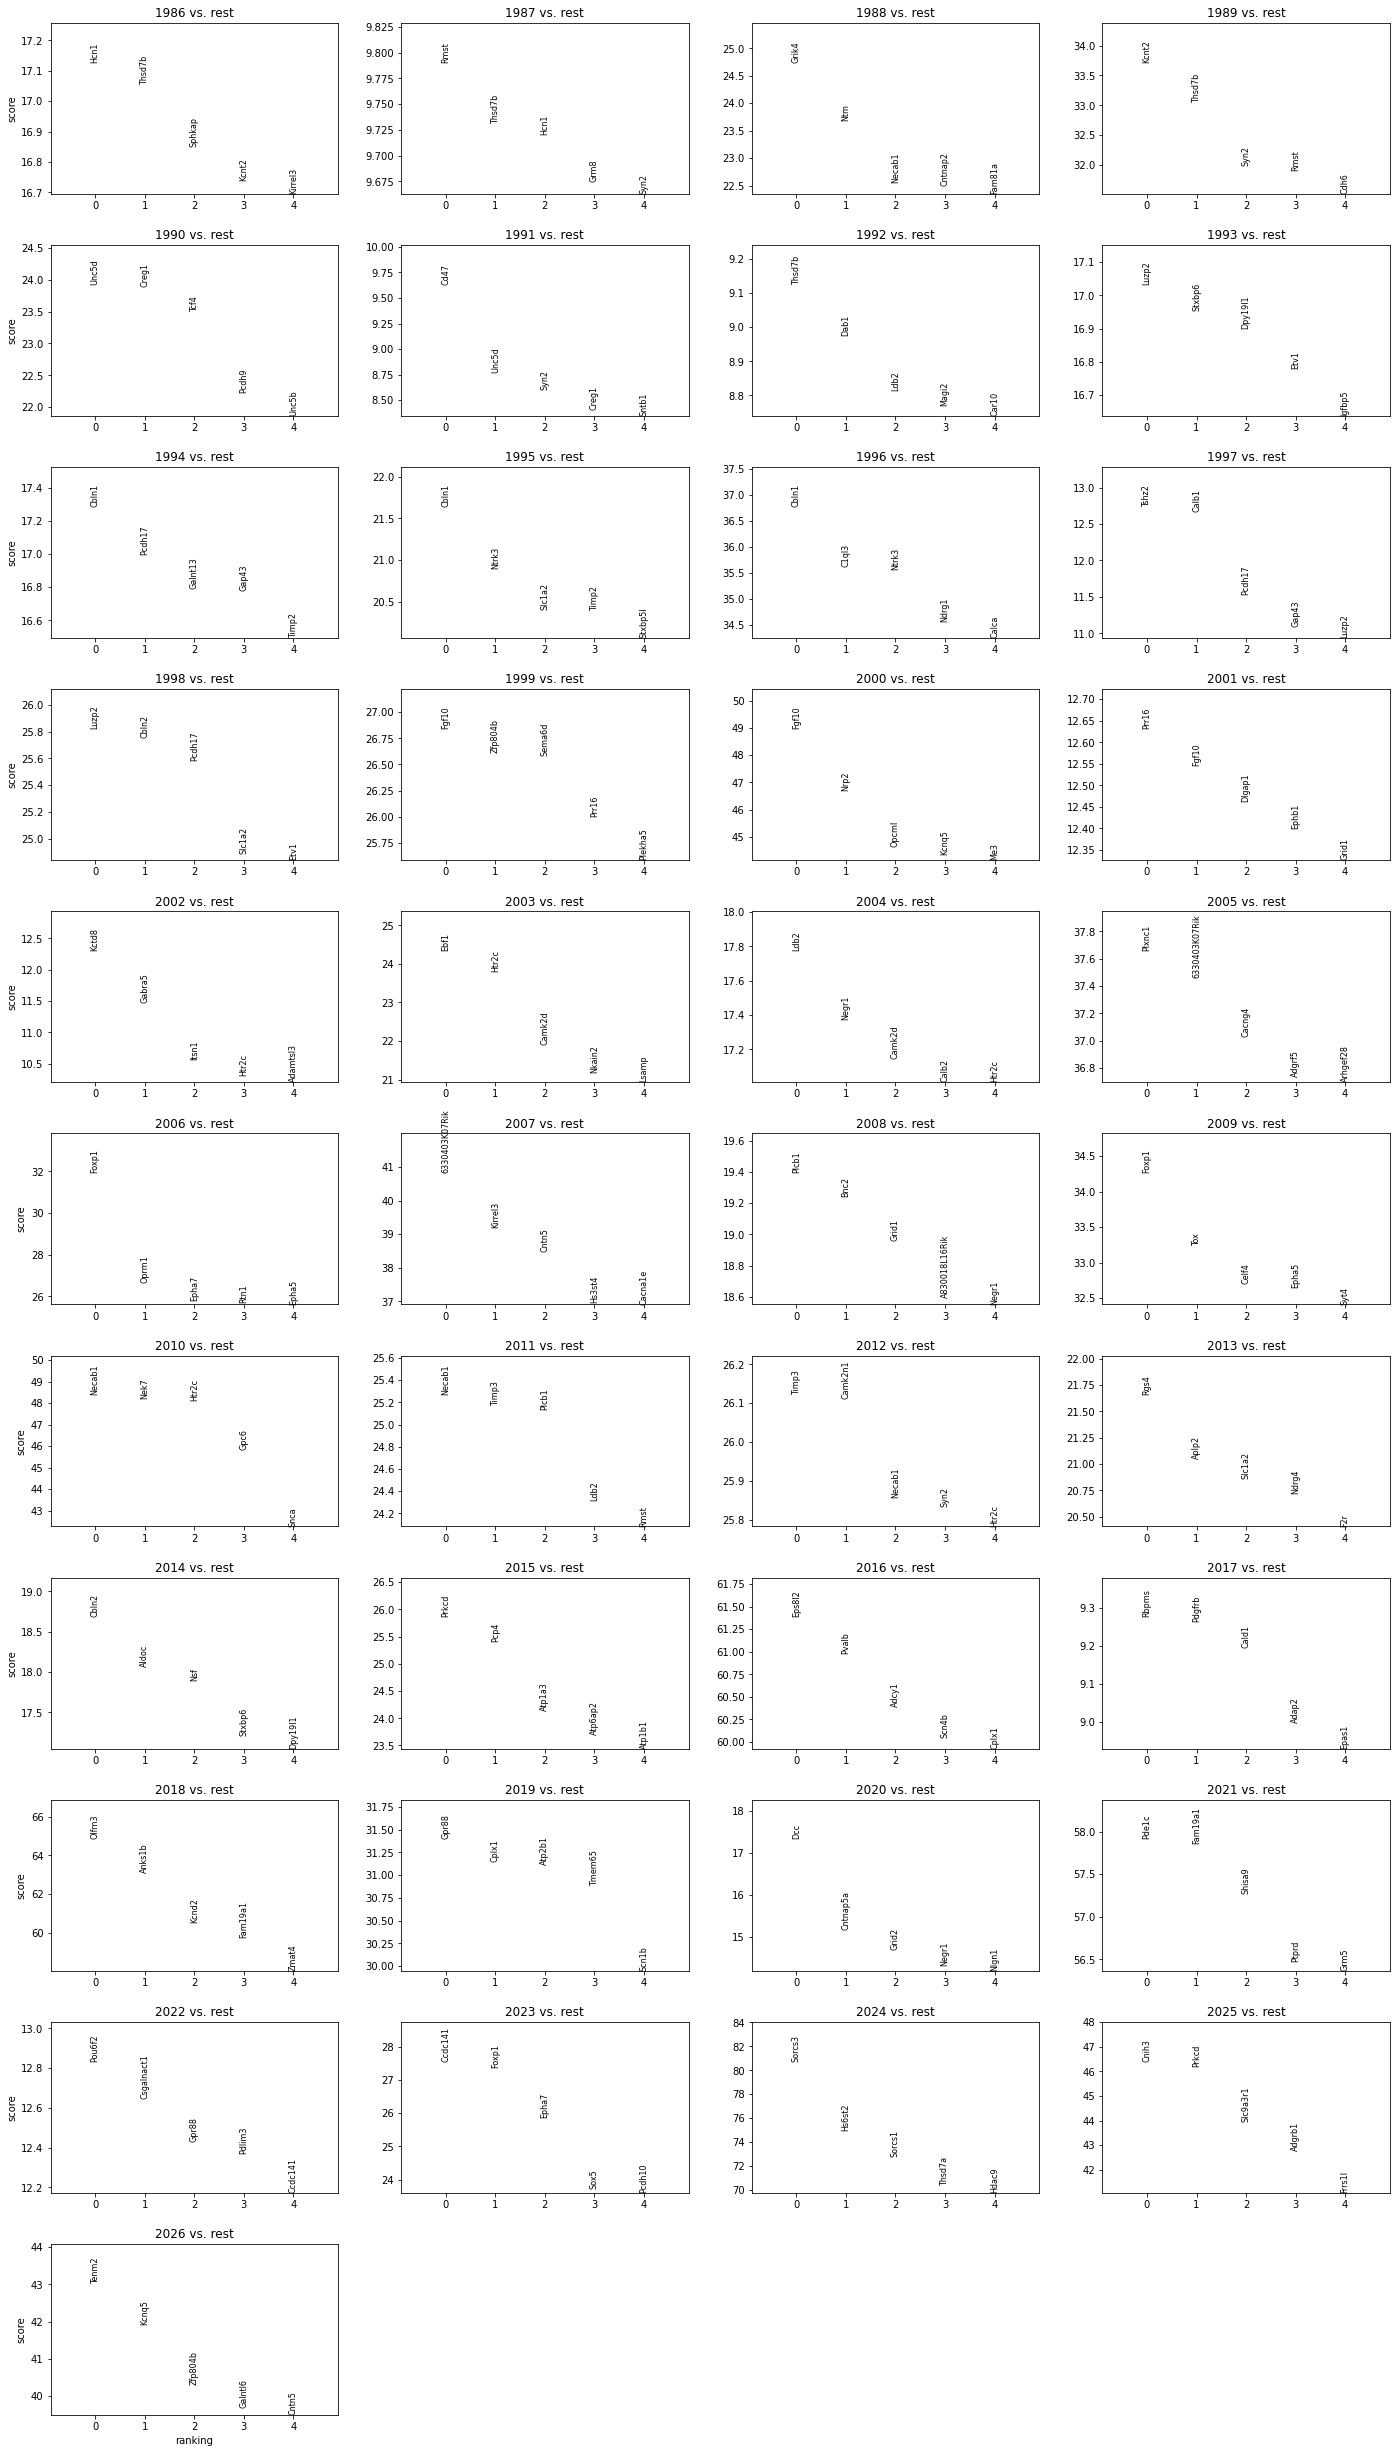

In [20]:
# Look for differential expression between clusters
sc.tl.rank_genes_groups(clData, 'cluster_id', method='wilcoxon', pts=True)
sc.pl.rank_genes_groups(clData, n_genes=5, sharey=False)

In [36]:
# Create a dataframe with list of gene scores, pvals, logfoldchanges, percentage expression
indx = "1999"
clRanked = pd.DataFrame(
        {key: clData.uns["rank_genes_groups"][key][indx]
        for key in ['names', 'pvals', 'scores', 'logfoldchanges']})
pts = clData.uns["rank_genes_groups"]["pts"][indx][genesRanked.names].reset_index(drop=True).rename("pts")
pts_rest = clData.uns["rank_genes_groups"]["pts_rest"][indx][genesRanked.names].reset_index(drop=True).rename("pts_rest")
pts_diff = pd.Series(pts - pts_rest, name="pts_diff")
clRanked = pd.concat([clRanked, pts, pts_rest, pts_diff], axis=1)
clRanked = clRanked.sort_values(by=["scores"], ascending=False, key=abs)
clRanked

,names,pvals,scores,logfoldchanges,pts,pts_rest,pts_diff
0,Fgf10,1.035680e-158,26.842363,11.551244,1.000000,1.000000,0.000000
1,Zfp804b,5.604671e-156,26.607191,7.739468,0.992308,0.999784,-0.007476
2,Sema6d,1.053364e-155,26.583498,5.132680,1.000000,0.981733,0.018267
23430,Galnt17,2.066934e-151,-26.209576,-4.878527,0.000000,0.000000,0.000000
3,Prr16,5.586447e-149,25.995371,8.829495,0.996154,0.999957,-0.003803
...,...,...,...,...,...,...,...
10811,Igkv4-83,1.000000e+00,0.000000,0.000000,0.007692,0.015150,-0.007458
10810,5730422E09Rik,1.000000e+00,0.000000,0.000000,0.003846,0.005887,-0.002041
10809,Igkv13-84,1.000000e+00,0.000000,0.000000,0.996154,0.994286,0.001868
10808,Igkv13-85,1.000000e+00,0.000000,0.000000,0.038462,0.025019,0.013442


(<Figure size 432x288 with 1 Axes>,
 <AxesSubplot:title={'center':'1999 vs rest reference'}, xlabel='Log2 Fold Change', ylabel='- Log10 ( pVal ) '>)

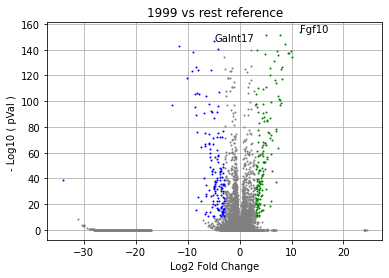

In [37]:
# Query volcano plots for various clusters
plotVolcano(clData,indx)

In [39]:
# Take top 500 "score" genes, filtered out for atleast 2 logfold change
clRanked = clRanked.sort_values(by=["scores"], ascending=False, key=abs)
clFiltered = clRanked.iloc[0:500,:]
clFiltered = clFiltered[clFiltered["logfoldchanges"] > abs(2)]
clFiltered = clFiltered.sort_values(by=["pts_diff"], ascending=False)
clFiltered

,names,pvals,scores,logfoldchanges,pts,pts_rest,pts_diff
96,Epha8,8.397005e-63,16.726545,4.263403,0.784615,0.186131,0.598484
105,Kcnk10,3.319720e-61,16.506039,3.724635,0.961538,0.486625,0.474914
90,Crim1,6.441614e-65,17.014229,2.162120,0.823077,0.435157,0.387920
73,Gpc5,7.690856e-73,18.051405,6.233515,0.784615,0.416198,0.368418
46,Timp2,5.111897e-97,20.902214,2.214747,0.988462,0.625097,0.363364
...,...,...,...,...,...,...,...
230,Ephb2,2.505397e-34,12.217544,2.884089,0.396154,0.751710,-0.355556
185,Zbtb7c,1.147642e-40,13.352354,4.120676,0.438462,0.833651,-0.395189
131,Pde9a,3.745562e-53,15.346372,3.215256,0.223077,0.647000,-0.423923
98,Pou2f2,4.240412e-62,16.629795,4.318831,0.488462,0.915332,-0.426870


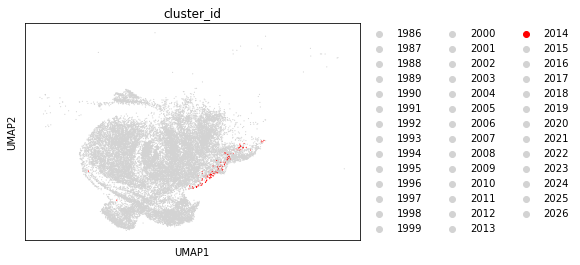

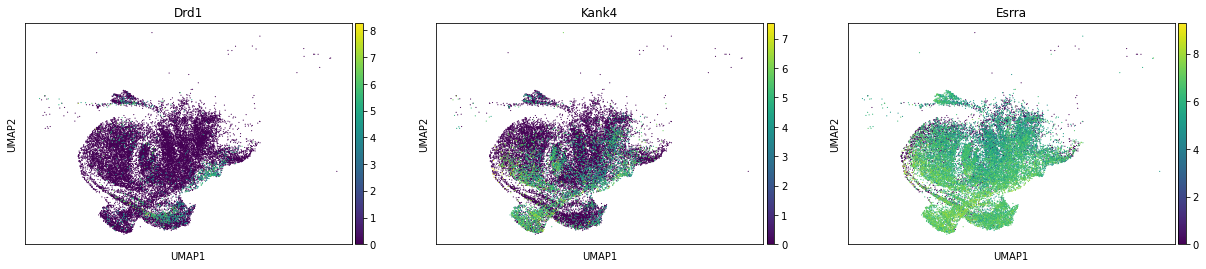

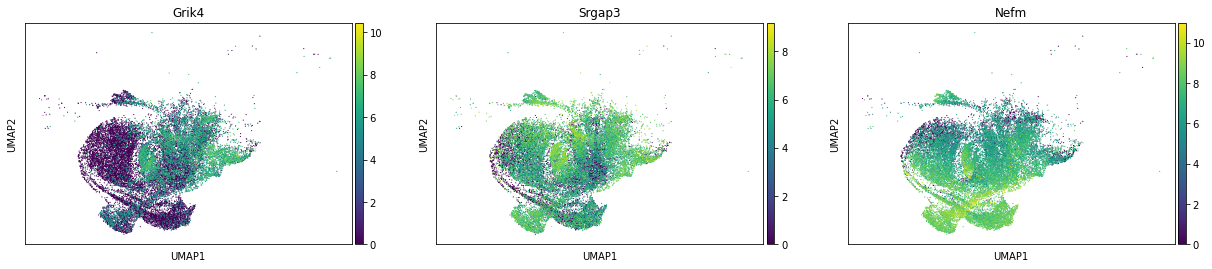

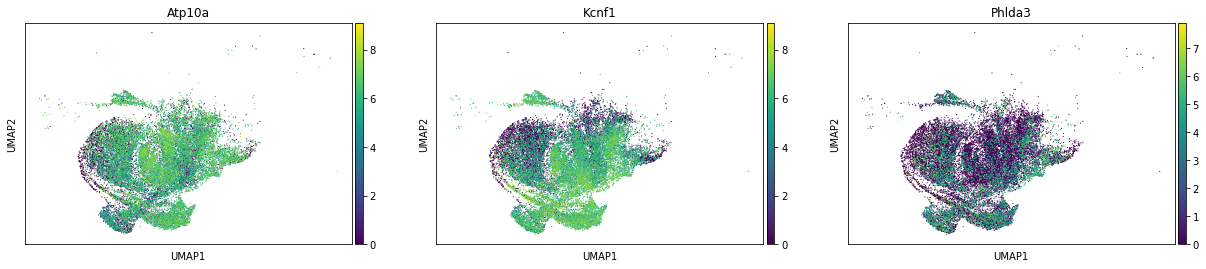

In [31]:
# Plot expression of several potential marker genes
maskPalette = create_mask_dict(clData.obs.cluster_id.unique(),indx)
sc.pl.embedding(clData, "umap", color = "cluster_id", palette=maskPalette)

sc.pl.umap(clData, color = clFiltered["names"][0:3])
sc.pl.umap(clData, color = clFiltered["names"][3:6])
sc.pl.umap(clData, color = clFiltered["names"][-3:])

## Other stuff

In [ ]:
# Allen ISH Links

# Prkcd appears to express in parataenial nucleus, MD, anteromedial, lots of others (exceptions are central
# medial and paracentral) along with non-thalamic, e.g. septal nuclei. Really seems to lable most of TH, w/
# perhaps some posterior preference
https://mouse.brain-map.org/experiment/show/70301274

#1999, Fgf10 perhaps lateral dorsal nucleus
https://mouse.brain-map.org/experiment/show/74513971

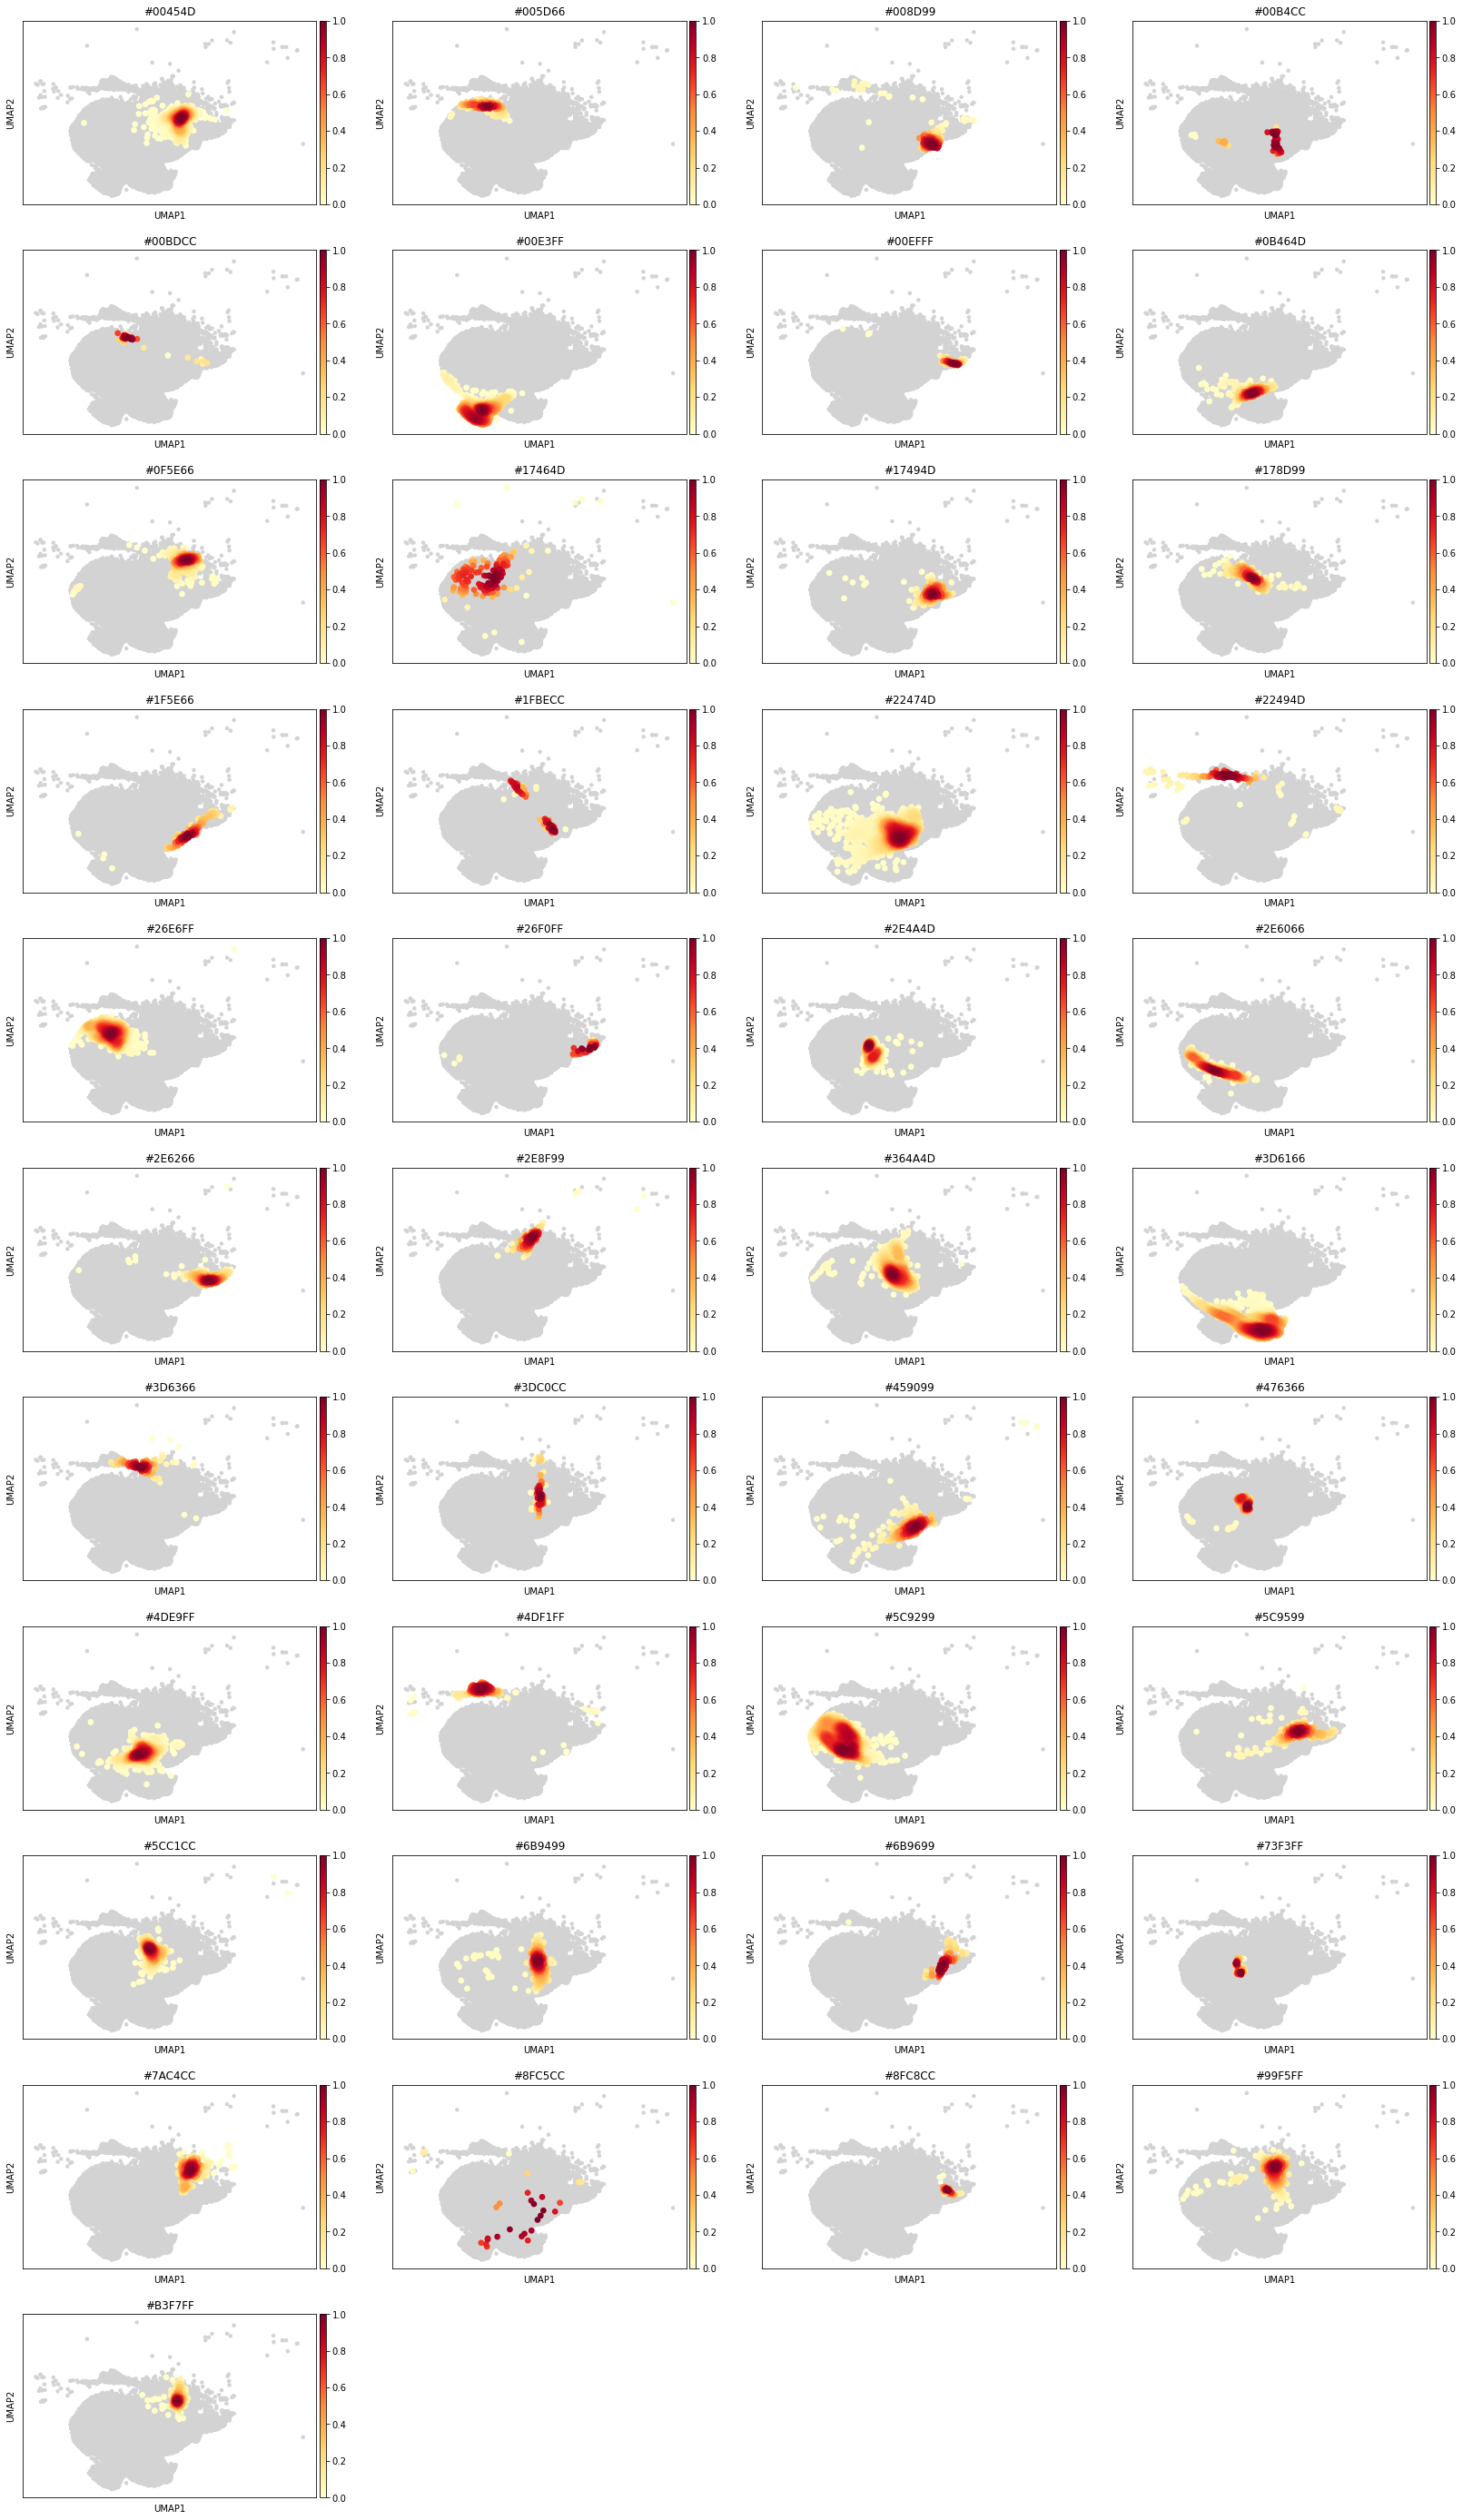

In [88]:
# Embedding densitt key seems to break down for fully numeric names, grouping by cluster color seems to work though
sc.tl.embedding_density(clData, basis="umap",groupby="cluster_color")
sc.pl.embedding_density(clData, basis="umap", key="umap_density_cluster_color")

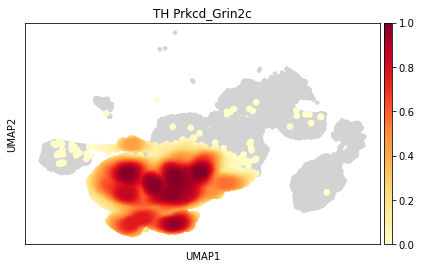

In [171]:
sc.pl.embedding_density(gluData, basis="umap", key="umap_density_subclass_label", group=indx)

## Misc

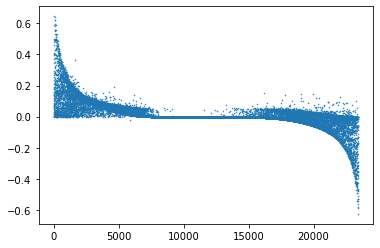

In [150]:
# Plot distribution of percentage differences w/ gene rank
fig, ax = plt.subplots()
ax.plot(range(len(genesRanked)), genesRanked.pts - genesRanked.pts_rest, '.',markersize=1)

## Compare to logistic regression

In [151]:
gluLogReg = gluData;
sc.tl.rank_genes_groups(gluLogReg,subclass_label,method = 'logreg')
# Need to confirm that gluData2 has separate "rank_gene_groups" structure than gluData

AnnData object with n_obs × n_vars = 57333 × 23431
    obs: 'sample_id', 'umi_counts', 'gene_counts', 'sex', 'facs', 'roi', 'roi_label', 'roi_color', 'cl', 'cluster_id', 'cluster_label', 'cluster_color', 'subclass_id', 'subclass_label', 'subclass_color', 'class_id', 'class_label', 'class_color', 'forebrain_cluster_label', 'forebrain_subclass_label', 'forebrain_neighborhood_label', 'qc'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'cl_colors', 'class_id_colors', 'class_label_colors', 'cluster_id_colors', 'hvg', 'neighbors', 'umap', 'rank_genes_groups'
    obsm: 'X_pca', 'X_umap'
    obsp: 'connectivities', 'distances'